<a href="https://colab.research.google.com/github/MegumuTsukamoto/Kaggle_001_Titanic/blob/main/04_%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ドライブ内にファイルアップロードする

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas-profiling
import pandas_profiling as pdp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 82.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=604b0dea25ecd7e8fde3630dbd30c5d845e0d251ca5754b6193a6ff990da8955
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


<ipython-input-2-788ab0e51aa6>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pdp


In [3]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認
import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# 日本語表示
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ccb73de230471bec37c5cbb3c9906a8f48b906f62df539495f9ae015c8d3abb1
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


$\large{\text{ベースライン作成}}$

$\large{\text{データセット}}$

データ項目の一覧

1: PassengerId   乗客ID

2: survived      生死	0 = No, 1 = Yes

3: pclass	チケットのクラス	1 = 1st, 2 = 2nd, 3 = 3rd

4: Name　　　名前

5: sex	性別

6: Age	年齢 （1歳未満は小数）

7: sibsp	同乗している兄弟または配偶者の人数

8: parch	同乗している親または子供の人数

9: ticket	チケット番号

10: fare	運賃

11: cabin	キャビン番号

12: embarked	乗船港	C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/001_Titanic/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


以下のデータ確認を行う

レコード数とカラム数の確認、カラムごとのデータの種類の確認、欠損値の確認（補間はまだしない）、etc....

In [5]:
# 元CSVと一致しているか確認
print(df_train.shape)
print('レコード数:', len(df_train))
print('カラム数:', len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


In [6]:
# レコード数やカラム数の他、データ型も確認しておく
# memory usage も分かる
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Pclass：チケットクラスは「順序尺度」（数値の順序に意味がある）であるものの、「間隔尺度」（数値の間隔に意味がある）ではない。よって、int型からカテゴリ変数（object型）に変更した方がモデルとしての精度が上がる可能性もある。

In [7]:
# データ型の変換はこうやる
df_train['Pclass'] = df_train['Pclass'].astype(object)
# オブジェクト型になっている
df_train[['Pclass']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pclass  891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [8]:
# 今回は数値のまま使うのでint型に戻しておく
df_train['Pclass'] = df_train['Pclass'].astype(int)
# int型になっている
df_train[['Pclass']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pclass  891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [9]:
# 欠損値の確認
df_train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [10]:
# 欠損値の個数
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

（注）いきなり欠損値の補間は行わないこと。明確な理由がないなら、そのままのデータを使う方が吉（欠損に意味がある場合もある）

In [11]:
# データセットの作成
# 今回は「Survived（生死）」を目的変数、「Pclass（チケットクラス）」と「Fare（運賃）」を説明変数と仮定
# チケットクラスや運賃が高い人の方が優先的に救助されて生き残りそうな感じ

x_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


（注）純粋なベースラインの評価を行いたいので、説明変数は最初は絞り込んだ状態からスタートするのが吉（徐々に増やしていく）。例えば、前処理の仕方が悪かったのかバリデーション設計が悪かったのかは、説明変数が少ない方が問題点の洗い出しがしやすくなる

$\large{\text{バリデーション設計}}$

ベースライン作成において最重要のプロセス（これから作成するモデルの精度を手元のデータのみで判断することが目的）。手元のデータ（学習に使うtrainデータ）で擬似的に検証データを作成し、未知のデータ（推論に使うtestデータ）に対する精度を確認することが過学習を防ぐ意味でも重要

バリデーション設計で課題となるのは、検証データをどのように作成するかが重要（実際の適用時と同じ状況を仮想的に再現するか）

例えば、「これからの1ヶ月は直近1ヶ月間と似た傾向がある」という仮説の場合、trainデータの中から直近1ヶ月間分のデータを抜き出しそれを検証データとする。

バリデーションの方法は、①学習データと検証データの適切な分け方、②検証の信頼性を上げる方法、の2つである。


①学習データと検証データの適切な分け方（具体的）

1.２値分類モデルで不均衡データの場合...trainデータ10万件のうち、目的変数「1」が5000件（5%）、目的変数「0」が残りの95％だとする。推論に使うtestデータの目的変数の割合は不明だが、trainデータとtestデータの傾向が同じという仮定のもとでは、trainデータを学習用・検証用ともに同じ95:5の割合になるように分割しておくのが吉である。

2.trainとtestに同じ顧客がいない場合...学習データと検証データで顧客を重複させないようにtrainデータを分割させるのが吉である。

3.時系列データの予測モデルの場合...時系列データで、trainデータ（直近9ヶ月）の後にtestデータ（将来3ヶ月）があるとする。この場合もtrainデータ（直近9ヶ月）を学習データ（直近6ヶ月）と検証データ（直近3ヶ月）に分離しておくのが吉である。


②検証の信頼性を上げる方法

1.ホールドアウト検証と2.交差検証（クロスバリデーション）の2つである。

1.ホールドアウト検証...上記のようにtrainデータを「1組の」学習データと検証データに分割する方法。学習が1回で済むことが長所であるが、検証用として分離したデータは学習に使われないという短所がある（データの数が少ない場合、明確にデメリットとなる）。また検証データの選び方にランダム性がある場合、それによってモデルの精度が変わる可能性もある。

2.クロスバリデーション...trainデータから「複数の」学習データと検証データの組を作成して複数回の学習を行う方法。例えば、5-foldクロスバリデーションの場合、trainデータを5個のブロックに分割し、1/5を検証用、4/5を学習用に使う（これを5サイクル行う）。trainデータの全てを学習に使うことができ、検証データの選び方による偏りを抑制できるという長所がある反面、複数回の学習を行うため時間がかかる短所がある。


In [12]:
# ホールドアウト検証
import sklearn
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# sklearnのtrain_test_splitでデータを分割
# test_size=0.2 で検証用は２割に
# stratify=y_train で正解ラベルのデータ比率に合わせて検証データが作られる（層化抽出）①
# random_state=123 という数値に特に意味はない（0で乱数シード固定）
# random_stateのデフォルトにはNoneが入っており、Noneのままだと、データのランダムな行の順番が固定されず、
# train_test_splitを再実行すると再実行前と異なるtrainデータ、testデータを返す
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
# Suvived「1」の割合がy_trainと同程度になっていることを確認①
print('y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}'.format(
    y_train['Survived'].mean(), y_tr['Survived'].mean(), y_va['Survived'].mean()
))

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


In [13]:
# 5-foldクロスバリデーション（交差検証）
n_splits = 5

# 目的変数の「0」と「1」の割合を揃えるために StratifiedKFold を使う
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

# 目的変数の「0」と「1」の割合が揃っていることを確認
for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print('y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}'.format(
    y_train['Survived'].mean(), y_tr['Survived'].mean(), y_va['Survived'].mean()
    ))
    # 後でここでモデル学習

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


LightGBNの長所...モデルの精度が高い、処理が高速、カテゴリ変数を数値に変換しなくても処理できる、欠損値があっても処理できる、異常値の影響を受けにくい

In [14]:
# ①モデル学習（ホールドアウト検証）
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

# ハイパーパラメータ（辞書）
# 後でチューニングする
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'
}
verbose_eval = 10  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

# モデルはLightGBMを使う
model = lgb.LGBMClassifier(**params)


# 2021年まで
# model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)],
        #   early_stopping_rounds=100, verbose=10
        # )

# 2022年から
model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)],
          callbacks=[lgb.early_stopping(stopping_rounds=100,
                                        verbose=True), # early_stopping用コールバック関数
                                        lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
        )

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [15]:
# 精度の評価
# 学習したモデルに検証データを入力して推論を実行後、精度を評価
# Titanicの場合、評価指標はAccuracy
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)
metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print('[accuracy] tr: {:.2f}, va: {:.2f}'.format(metric_tr, metric_va))

[accuracy] tr: 0.75, va: 0.73


In [16]:
# 説明変数の重要度（寄与度）の特定
# 大きいほど効いている説明変数とわかる
# この例だと、「Pclass（チケットクラス）」より「Fare（運賃）」の方がより効いている説明変数
imp = pd.DataFrame({'col':x_train.columns, 'imp':model.feature_importances_})
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


In [17]:
# ②モデル学習（クロスバリデーション）

# ハイパーパラメータ（辞書）
# 後でチューニングする
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'
}
verbose_eval = 100  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

metrics = []
imp = pd.DataFrame()

# 5-Fold
n_splits = 5

# 上段の再掲
# 目的変数の「0」と「1」の割合を揃えるために StratifiedKFold を使う
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

# 5回学習する
for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print('y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}'.format(
    y_train['Survived'].mean(), y_tr['Survived'].mean(), y_va['Survived'].mean()
    ))

    # ここでモデル学習
    # モデルはLightGBMを使う
    model = lgb.LGBMClassifier(**params)


    # 2021年まで
    # model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)],
            #   early_stopping_rounds=100, verbose=10
            # )

    # 2022年から
    model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)],
            callbacks=[lgb.early_stopping(stopping_rounds=100,
                                            verbose=True), # early_stopping用コールバック関数
                                            lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
            )

    # 精度の評価
    # 学習したモデルに検証データを入力して推論を実行後、精度を評価
    # Titanicの場合、評価指標はAccuracy
    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print('[accuracy] tr: {:.2f}, va: {:.2f}'.format(metric_tr, metric_va))
    metrics.append([nfold, metric_tr, metric_va])

    # 説明変数の重要度（寄与度）の特定
    # 大きいほど効いている説明変数とわかる
    # この例だと、「Pclass（チケットクラス）」より「Fare（運賃）」の方がより効いている説明変数
    _imp = pd.DataFrame({'col':x_train.columns, 'imp':model.feature_importances_, 'nfold':nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*20, 'result', '-'*20)
metrics = np.array(metrics)
print(metrics)

print('[cv ] tr:{:.2f}+-{:.2f}, va:{:.2f}+-{:.2f}'.format(
    metrics[:,1].mean(), metrics[:,1].std(),
    metrics[:,2].mean(), metrics[:,2].std()
))

imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp.columns = ['imp', 'imp_std']
imp = imp.reset_index(drop=False)

print('Done.')


-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
Early stopping, best iteration is:
[12]	training's auc: 0.793779	valid_1's auc: 0.740382
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[LightGBM] [Info] Number of positive: 2

In [18]:
# 説明変数の重要度（寄与度）の特定
# ホールドアウト検証と同様、「Pclass（チケットクラス）」より「Fare（運賃）」の方がより効いている説明変数
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


ベースラインの評価...ベースライン、特にバリデーション設計の正しさを確かめるために、ベースライン検証用のデータを用意しておくと吉。具体的には、手元のデータからまずベースライン検証用のデータを切り出し（時系列データなら直近）、残りのデータを学習用と検証用に分割する。切り出す時期によってバラツキが大きい場合は、切り出す時期をずらしながらベースライン検証用を複数用意しても良い（交差検証と同じ考え方）。ベースライン検証は、特徴量エンジニアリングとモデルチューニングでは省略しても続けてもいい。

また、交差検証をしていればある程度のリスク分散はされているので不要である（実務では用意した方が吉）。Kaggleのようなコンペでは、testデータの一部を使って評価値を参加者に提示している（リーダーボード）。そのため、バリデーション設計に問題があったらサブミット後に分かるケースが多い。一方で、実務ではリーダーボードがないので、自分でベースライン検証用のデータとベースライン検証の仕組みを用意するのが吉

ベースラインの良し悪しを評価する観点

①モデルの精度...検証用データとベースライン検証用データの精度のギャップが小さいことを確認する。分析設計で設定した評価指標を計算する

②誤差の分布...検証用データとベースライン検証用データで誤分類の傾向が似ていることを確認する。（分類：混合行列を比較、回帰：誤差値やヒストグラムの形状を比較）

③予測値の分布...検証用データとベースライン検証用データで分布が似ていることを確認する。（分類：正解ラベルごとに予測値のヒストグラムを作成し比較、回帰：正解と予測値の散布図）

In [19]:
# ベースライン検証用データ（va2）の作成
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


In [24]:
# 残りのデータを学習用（tr1）と検証用（va1）に分割（ホールドアウト検証用に）
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr, y_tr, test_size=0.2, shuffle=True, stratify=y_tr, random_state=789)

print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


In [25]:
# ベースライン検証用データを準備した状態でモデル学習（ここではホールドアウト検証のみ）

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'
}
verbose_eval = 10  # この数字を1にすると学習時のスコア推移がコマンドライン表示される

# モデルはLightGBMを使う
model = lgb.LGBMClassifier(**params)

model.fit(x_tr1, y_tr1, eval_set=[(x_tr1, y_tr1), (x_va1, y_va1)],
          callbacks=[lgb.early_stopping(stopping_rounds=100,
                                        verbose=True), # early_stopping用コールバック関数
                                        lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
        )

[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[20]	training's auc: 0.810025	valid_1's auc: 0.712087
[30]	training's auc: 0.822545	valid_1's auc: 0.72376
[40]	training's auc: 0.829204	valid_1's auc: 0.719421
[50]	training's auc: 0.836699	valid_1's auc: 0.720455
[60]	training's auc: 0.841808	valid_1's auc: 0.716322
[70]	training's auc: 0.84684	valid_1's auc: 0.71281
[80]	training's auc: 0.851009	valid_1's auc: 0.716529
[90]	training's auc: 

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

In [26]:
# ①精度の評価
# 学習したモデルに検証データ（va1）、ベースライン検証データ（va2）を入力して推論を実行後、精度を比較
# Titanicの場合、評価指標はAccuracy
y_tr_pred = model.predict(x_tr)
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va1 = accuracy_score(y_va1, y_va1_pred)
metric_va2 = accuracy_score(y_va2, y_va2_pred)

print('[学習用データ] acc: {:.4f}'.format(metric_tr))
print('[検証用データ] acc: {:.4f}'.format(metric_va1))
print('[ベースライン検証用データ] acc: {:.4f}'.format(metric_va2))

[学習用データ] acc: 0.7135
[検証用データ] acc: 0.7133
[ベースライン検証用データ] acc: 0.7095


In [27]:
# ②誤差の分布
# ２値分類なので混合行列（confusion matrix）を計算して比較
# 検証用とベースライン検証用でヒートマップが類似していたらOK
print('検証用データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証用データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証用データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


In [28]:
# 混合行列（confusion matrix）の見方
# 対角成分が正解=予測となっている件数
conf_mat = pd.DataFrame(confusion_matrix(y_va1, y_va1_pred),
                        index=['正解=0', '正解=1'],
                        columns=['予測=0', '予測=1'])
conf_mat

,予測=0,予測=1
正解=0,76,12
正解=1,29,26


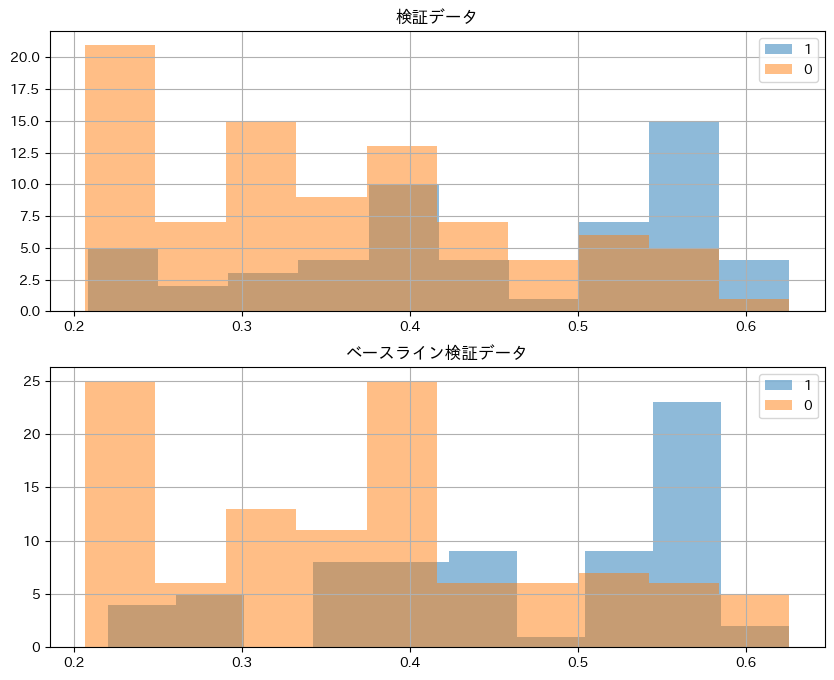

In [29]:
# ③予測値の分布を比較

# 予測値の確率
y_va1_pred_prob = model.predict_proba(x_va1)[:, 1]
y_va2_pred_prob = model.predict_proba(x_va2)[:, 1]


# 確率分布を可視化
fig = plt.figure(figsize=(10, 8))

# 検証データ
fig.add_subplot(2,1,1)
plt.title('検証データ')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

# ベースライン検証データ
fig.add_subplot(2,1,2)
plt.title('ベースライン検証データ')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

バリデーション設計を終えた段階で一度未知のデータで推論処理を行なっていく

In [31]:
# 推論データの準備
# 「Survived」はない
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/001_Titanic/test.csv')
x_test, id_test = df_test[['Pclass', 'Fare']], df_test[['PassengerId']]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [32]:
# 学習したモデルを未知のデータ（testデータ）を推論
y_test_pred = model.predict(x_test)

In [33]:
# 提出用ファイルの作成
# 予測値「Survived」に「PassengerId」を付与する
# 1列目に「PassengerId」、2列目に「Survived」とした形式が定められたフォーマット
df_submit = pd.DataFrame({'PassengerId': id_test['PassengerId'], 'Survived': y_test_pred})
display(df_submit.head(5))

# CSVファイルとしてエクスポート（Colab内に保存される）
df_submit.to_csv('submission_baseline.csv', index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [34]:
# ローカルにも保存しておく
from google.colab import files
files.download('submission_baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ベースライン作成段階では、まだ特徴量エンジニアリングもハイパーパラメータのチューニングも行なっていないため、Submit Predictionしてもそんな精度は高くない（Score: 0.69617）